In [5]:
%run Base.ipynb

**GENERATING PLUMMER SPHERE**

$$p(r) = \frac{1}{M} 4 \pi r^2 \rho(r) =  \frac{1}{M} 4 \pi r^2 \frac{3M}{4\pi b^3} \left(1+\frac{r^2}{b^2}\right)^{-5/2} = \frac{3r^2}{ b^3} \left(1+\frac{r^2}{b^2}\right)^{-5/2}$$

$$P(r) =  \int_0^r p(r) dr = \frac{r^3}{b^3\left(1+\frac{r^2}{b^2}\right)^{3/2}}$$ (by parts and with $tan$ sobstitution)

It's mush easier to derive the potential:
 
$$p(r)=\frac{1}{M} 4 \pi r^2 \rho(r)=\frac{1}{M} 4 \pi \frac{\nabla^2\Phi}{4\pi G}=\frac{1}{GM}\frac{d}{dr}\left(r^2 \frac{d\Phi}{dr}\right)$$ 

$$P(r) =  \int_0^r p(r) dr = \frac{1}{GM} r^2 \frac{d\Phi}{dr} =  \frac{1}{GM} r^2\frac{d}{dr} \left( -\frac{GM}{\sqrt{r^2+b^2}}\right)=\frac{r^3}{b^3\left(1+\frac{r^2}{b^2}\right)^{3/2}}$$

$$\int_0^\infty p(r) dr = 1$$

$r/b=\sinh(x)$ ; $P=\tanh^3(x)$ ; $r=b\sinh(arctanh(P^{1/3}))$





In [2]:
class Plummer(Galaxy):
    
    def __init__(self,N,b,m=1):
        self.N = int(N) ; self.b = b ; self.m = m ; self.M = N*self.m 
        self.rho0 = 3*self.M/(4*np.pi*self.b**3)
        super().__init__(self.N)
        
        print("Plummer sphere of %i stars of mass %.2f. Scale parameter b is %.2f parsecs, total mass is %.2f solar masses" %(self.N, self.m, self.b, self.M))
    
        pos_cart = [] ; vel_cart = [] ; self.R = [] ; self.V = [] ; self.E = []
        
        for i in range(self.N):
            u = random.uniform(0,1); v = random.uniform(0,1); w = random.uniform(0,1)
            r = self.b*np.sinh(np.arctanh(u**(1/3)))
            self.R.append(r)
            theta = np.arccos(1-2*v) ; phi = 2*np.pi*w
            pos_cart.append([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])
        self.R = np.array(self.R)
        
        q_vector = []
        norm = 7*np.pi/512
        while(len(q_vector) < self.N): 
            q = random.uniform(0,1) ; y = random.uniform(0,0.093/norm) 
            if y < (1/norm) * q**2 * (1-q**2)**(7/2): q_vector.append(q) 

        for i in range(self.N):
            v = q_vector[i]*np.sqrt(2*self.M/np.sqrt(self.R[i]**2+self.b**2))
            self.V.append(v) 
            theta_v = np.arccos(1-2*random.uniform(0,1)) ; phi_v = 2*np.pi*random.uniform(0,1)
            vel_cart.append([v*np.sin(theta_v)*np.cos(phi_v),v*np.sin(theta_v)*np.sin(phi_v),v*np.cos(theta_v)])
            self.E.append(self.M/np.sqrt(self.R[i]**2+self.b**2)-1/2 * v**2)
        self.V = np.array(self.V) ; self.E = np.array(self.E)
        
        initial_system = []
        for i in range(self.N):
            initial_system.append(Star(self.m, pos_cart[i], vel_cart[i]))
        self.n_body_system.append(np.array(initial_system))
        
        #t_dynamical t_cross and t_relax
        self.r_median = np.median(self.R) ; self.v_median = np.median(self.V)
        self.t_cross = self.r_median/self.v_median
        self.t_relax = (0.1*N/np.log(N))*self.t_cross
        self.dynamical_time = self.t_cross
        print("t_cross time is %f in internal units, %f Myr. t_relax time is %f in internal units, %f Myr" %(self.t_cross, self.t_cross*time_conv,self.t_relax, self.t_relax*time_conv))

        #check on mass distribution

        r_array = np.logspace(-2,2,10)*self.b
        E_array = np.linspace(0,self.M/self.b,20)
        
        R_hist = np.histogram(self.R, bins=r_array)

        
        R_bin = [] ; R_dens = [] ; R_err = []
        for i in range(len(R_hist[1])-1):
            if R_hist[0][i] > 0:
                R_bin.append((R_hist[1][i]+R_hist[1][i+1])/2)
                V = 4/3 * np.pi * (R_hist[1][i+1]**3 - R_hist[1][i]**3) 
                R_dens.append(R_hist[0][i] / V)
                R_err.append(1/np.sqrt(R_hist[0][i])) #/V 
        R_bin = np.array(R_bin) ; R_dens = np.array(R_dens); R_err = np.array(R_err)


        def integrand(r,E):
            if  self.M/np.sqrt(r**2+self.b**2) >= E: #+ M_bh/r
                return 16*np.pi**2 * r**2 * np.sqrt(2*(self.M/np.sqrt(r**2+self.b**2)-E))
            else:
                return 0  

        E_hist = np.histogram(self.E, bins=E_array)  
        E_bin = [] ; E_dens = [] ; E_err = []
        for i in range(len(E_hist[1])-1):
            if E_hist[0][i] > 0:
                E_bin.append((E_hist[1][i]+E_hist[1][i+1])/2)
                V = integrate.quad(lambda E : integrate.quad(integrand,0.,np.inf,args=(E))[0],E_hist[1][i],E_hist[1][i+1])[0] 
                E_dens.append(E_hist[0][i] / V)
                E_err.append(1/np.sqrt(E_hist[0][i])) #/V 
        E_bin = np.array(E_bin) ; E_dens = np.array(E_dens); E_err = np.array(E_err)

        

        ### plots ###

        rho = self.rho0*(1+r_array**2/self.b**2)**(-5/2)

        F = 1/(1.5266 * integrate.quad(lambda r : (self.M/np.sqrt(r**2+self.b**2))**5 ,0,np.inf)[0])
        
        DF = F*E_array**(7/2)

        fig, axes = plt.subplots(1,2, figsize=(8,4),layout="constrained") 
        fig.suptitle('Plummer model') #fontsize=12
        
        axes[0].plot(np.log10(r_array/self.b),np.log10(rho/self.rho0),c='red')
        axes[0].errorbar(np.log10(R_bin/self.b),np.log10(R_dens/self.rho0),yerr=R_err, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black')
        axes[0].set_xlabel("log($r/b$)")
        axes[0].set_ylabel("log($\\rho/\\rho_0$)")

        axes[1].plot(E_array,np.log10(DF),c='blue')
        axes[1].errorbar(E_bin,np.log10(E_dens),yerr=E_err, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black')

        print(np.log10(E_dens))









Plummer sphere of 1000 stars of mass 1.00. Scale parameter b is 10.00 parsecs, total mass is 1000.00 solar masses
t_cross time is 2.628477 in internal units, 0.176289 Myr. t_relax time is 38.051096 in internal units, 2.552049 Myr


/tmp/ipykernel_72536/1717659855.py:75: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  V = integrate.quad(lambda E : integrate.quad(integrand,0.,np.inf,args=(E))[0],E_hist[1][i],E_hist[1][i+1])[0]
/tmp/ipykernel_72536/1717659855.py:75: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  V = integrate.quad(lambda E : integrate.quad(integrand,0.,np.inf,args=(E))[0],E_hist[1][i],E_hist[1][i+1])[0]
/tmp/ipykernel_72536/1717659855.py:98: RuntimeWarning: divide by zero encountered in log10
  axes[1].plot(E_array,np.log10(DF),c='blue')


[-14.17828389  -7.68166287  -6.98874958  -6.40575229  -6.10022873
  -5.73429775  -5.38169529  -5.1997683   -5.05032086  -4.88472531
  -4.67473114  -4.56821413  -4.42957934  -4.30125288  -4.22347355
  -4.13885207  -3.97425607  -3.99889114]


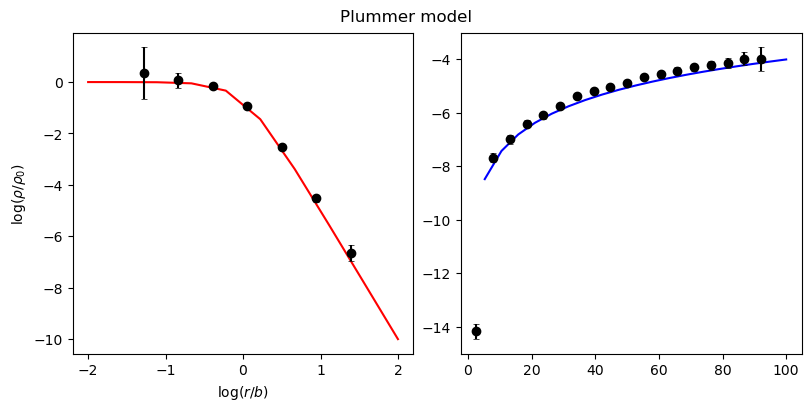

In [3]:
plum = Plummer(1000,b=10)

In [6]:
virial(plum)

-0.5018422925504408


In [107]:
eps = 10**-4 * ((4/3)*np.pi*plum.b**3/plum.N)**(1/3) 
evolve_treecode(plum, "plum", tstart=0,tstop=10, dtime = 0.1, eps = eps)

Galaxy evolved to time 10.00: 101 frames


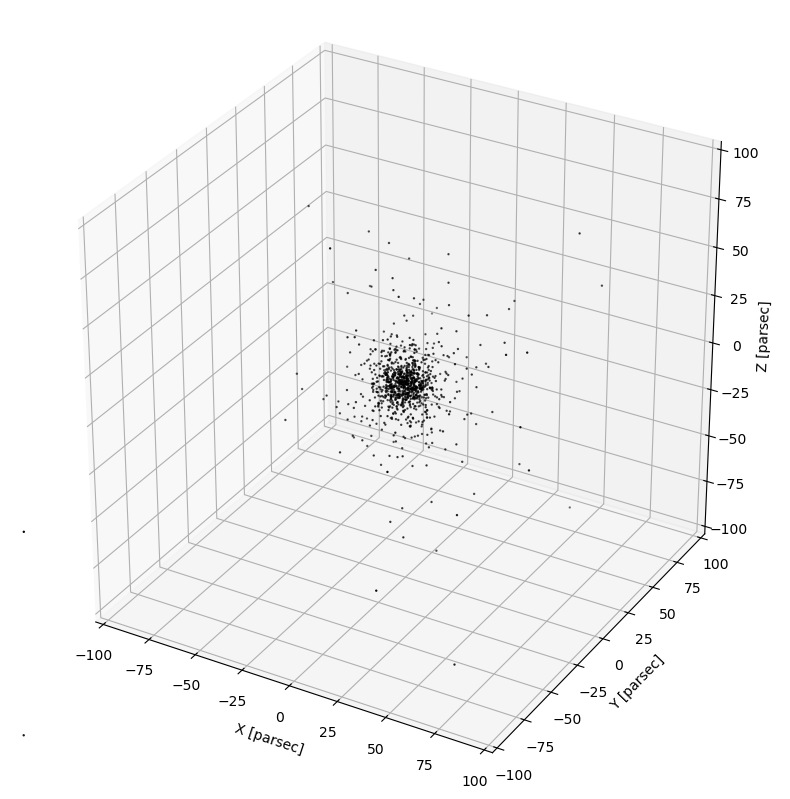

In [108]:
view(plum,r_max=100,time=0)

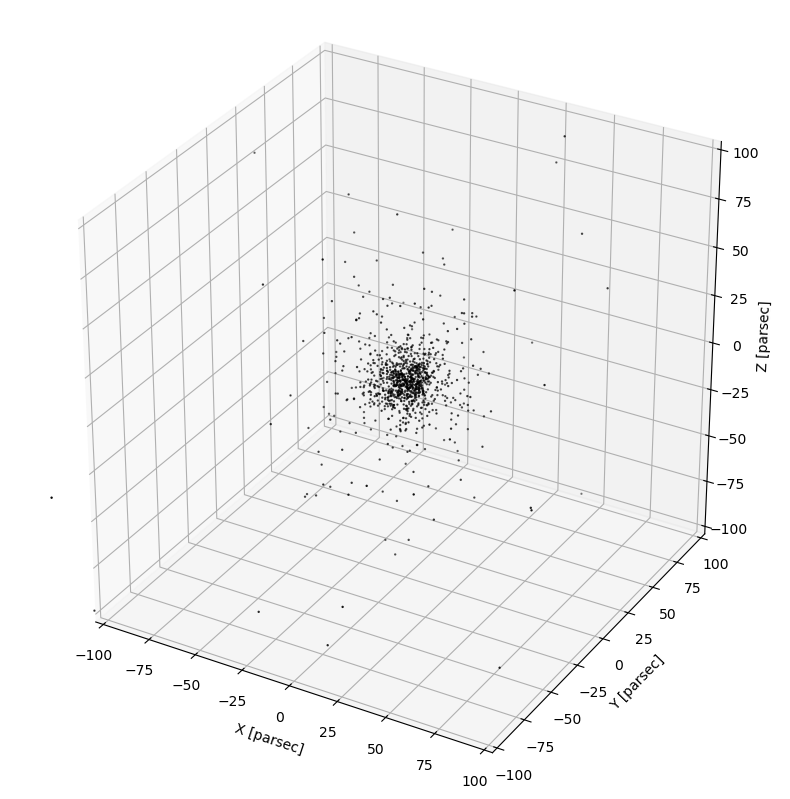

In [109]:
view(plum,r_max=100,time=10)

In [110]:
evolve_treecode(plum, "plum", tstart=10,tstop=50, dtime = 0.1, eps = eps)

Galaxy evolved to time 50.00: 500 frames


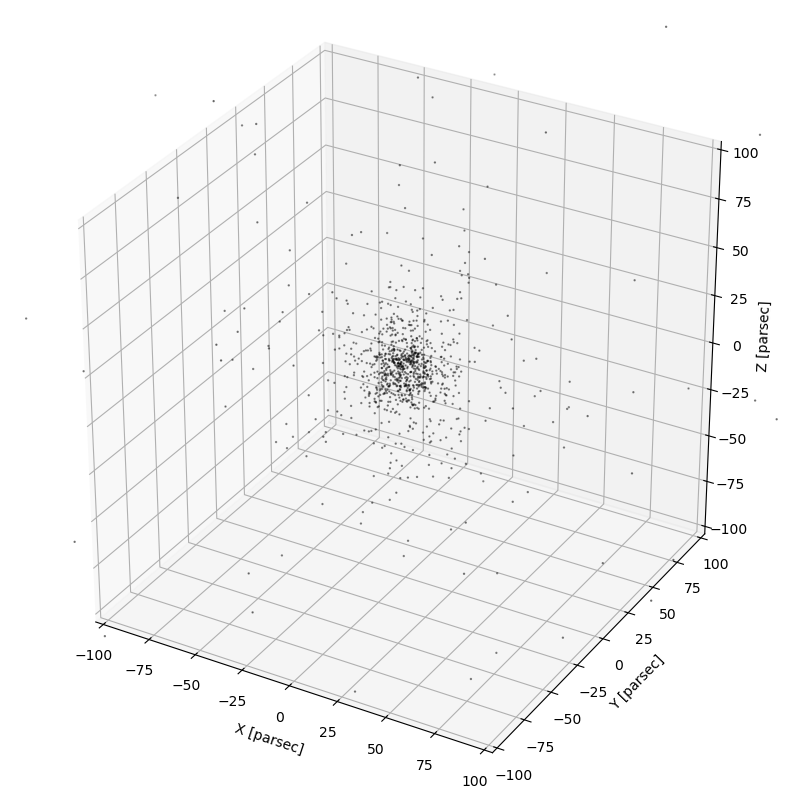

In [111]:
view(plum,r_max=100,time=50)